In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline 

### Picking Up Data From Fusion

In [4]:
threedo = pd.read_excel("ft0315.xlsx", "3 Days Out")
onedo = pd.read_excel("ft0315.xlsx", "1 Day Out")
bs = pd.read_excel("ft0315.xlsx", "Before Shift")
lm = pd.read_excel("ft0315.xlsx", "Last Minute")


### Merged All Fusion Scenarios

In [5]:
fusion = pd.concat([threedo, onedo, bs, lm], axis=0, sort=False, ignore_index=True)


In [6]:
#df savepoints 
threedo_orig = threedo
onedo_orig = onedo
bs_orig = bs
lm_orig = lm
fusion_orig = fusion

In [7]:
def ResetDFs() :
    threedo = threedo_orig
    onedo = onedo_orig
    bs = bs_orig
    lm = lm_orig
    fusion = fusion_orig

In [8]:
def DropBagatelle(dfName) :
     dfName = dfName[dfName['Venue Name'] != 'Bagatelle Miami']

#this cleans up the dataframe removing the columns that doesn't really give any importance to the variation.

def dfCleanUp(dfName) :
    DropBagatelle(dfName)
    dfName = dfName.loc[:, ['Venue Name', 
                      'Time Zone', 
                      'Party Size',
                      'Reservation Date', 'Res Time (Local to Restaurant)', 
                      'Available OT', 
                      'Available 7R']]
    #transforms Yes/No entries in Availability Column to 1's and 0's so that we can take a statistical analysis
    dfName['Available OT'] =  dfName['Available OT'].map(dict(Yes=1, No=0))
    dfName['Available 7R'] =  dfName['Available 7R'].map(dict(Yes=1, No=0))
    dfName['+/- for 7R'] = dfName['Available OT'] - dfName['Available 7R']
    dfName['Res Time (Local to Restaurant)'] = dfName['Res Time (Local to Restaurant)'].astype(str)
    
    #adds an additional day of the week to visualize if there's a relationship in the table availability depending on day of the week
    dfName['Day of Week'] = dfName['Reservation Date'].dt.day_name()
    #drops NA values. This might greatly alter the data tho.
    dfName.dropna(inplace=True)
    return dfName

#sets up a bar graph. side by side average yes/no's for all party sizes.
def BarGraphIt(dfName, ColName) :    
    
    #groups by the desired column, transforms it to a data frame with Available 7R and OT columns only, then takes the mean
    gb = dfName.groupby(['{}'.format(ColName)], sort=False)[['Available 7R', 'Available OT']].mean()
    gb.dropna(inplace=True)        
    #takes the labels used for graphing
    labels = dfName['{}'.format(ColName)].dropna().apply(str).unique()
    series = np.arange(len(labels))
    
    #heights of the bars of the graph depending on
    bh1 = np.array(gb['Available OT'])
    bh2 = np.array(gb['Available 7R'])
    
    ax = plt.subplot(111)
    ax.bar(series+0.3,bh1, width=0.4, color='firebrick', align='center')
    ax.bar(series,bh2, width=0.4, color='darkslategray', align='center')
    plt.xticks(ticks=series, labels = labels)
    plt.xlabel(ColName)
    plt.ylabel("Average Available Tables (All Party Sizes)")
    
    colors = {'OpenTable':'firebrick', 'SevenRooms':'darkslategray'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels, loc='lower right')
    
def DoDaThing(dfName, ColName) :
    df = dfCleanUp(dfName)
    BarGraphIt(df, ColName)


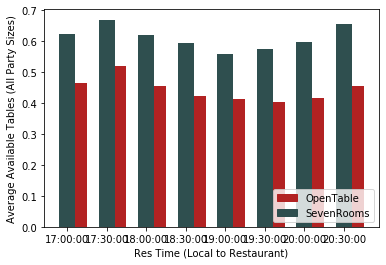

In [9]:
DoDaThing(threedo, 'Res Time (Local to Restaurant)')

7R has more opportunities every day at any hour, by average.

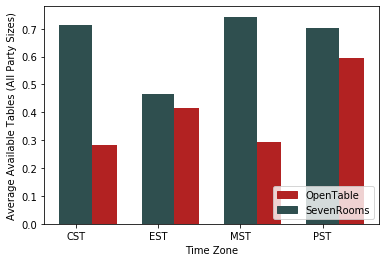

In [10]:
DoDaThing(threedo, 'Time Zone')

7R has the best overwhelming opportunities at Central, then at Mountain. Neck to neck at Eastern, and slight lead at Pacific.

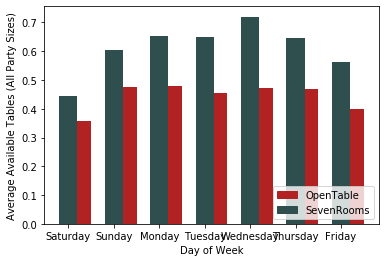

In [11]:
DoDaThing(threedo, 'Day of Week')

Best opportunities on Wednesdays

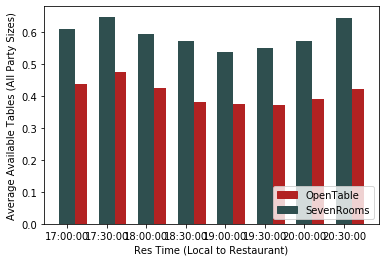

In [12]:
DoDaThing(onedo, 'Res Time (Local to Restaurant)')

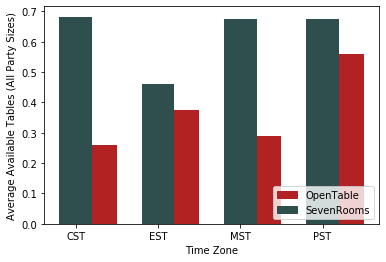

In [13]:
DoDaThing(onedo, 'Time Zone')

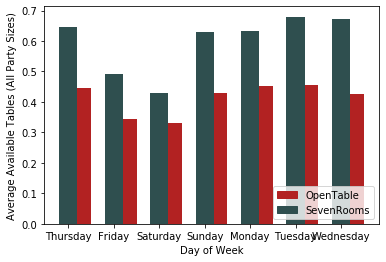

In [14]:
DoDaThing(onedo, 'Day of Week')

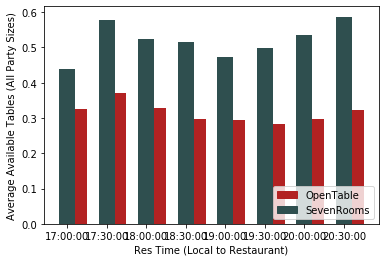

In [15]:
DoDaThing(bs, 'Res Time (Local to Restaurant)')

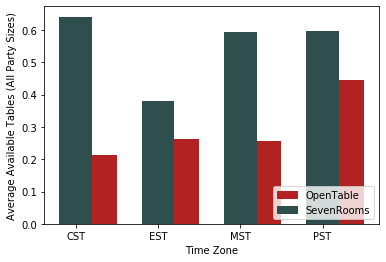

In [16]:
DoDaThing(bs, 'Time Zone')

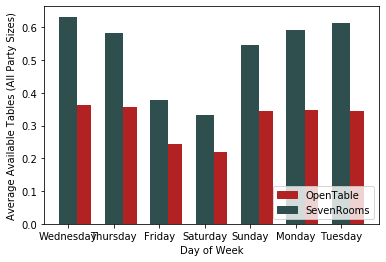

In [17]:
DoDaThing(bs, 'Day of Week')

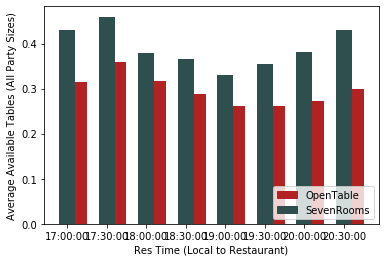

In [18]:
DoDaThing(lm, 'Res Time (Local to Restaurant)')

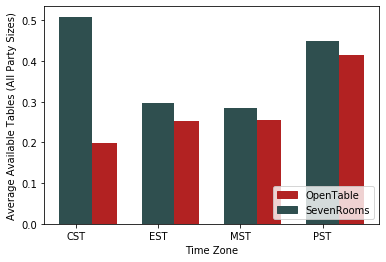

In [19]:
DoDaThing(lm, 'Time Zone')

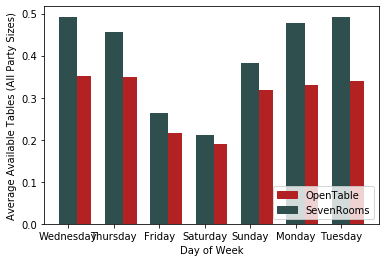

In [20]:
DoDaThing(lm, 'Day of Week')

In [21]:
ResetDFs()

In [38]:
def HeatMapIt(dfName, scenario) :
    plt.rcParams["figure.figsize"] = (10, 15)
    color = "RdBu"
    yticklabels = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    xticklabels = ['17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30']

    cleandf = dfCleanUp(dfName)

    cdfwp = cleandf.groupby(['Party Size', 'Day of Week', 'Res Time (Local to Restaurant)'], sort=False)[['Available OT', 'Available 7R', '+/- for 7R']].mean()
    cdf = cleandf.groupby(['Day of Week', 'Res Time (Local to Restaurant)'], sort=False)[['Available OT', 'Available 7R', '+/- for 7R']].mean()
    stawp = cdfwp.to_xarray().to_array()
    sta = cdf.to_xarray().to_array()

    AOT = sta[0]
    A7R = sta[1]
    Opp = sta[2]

    OppParty2 = stawp[2][0]
    OppParty4 = stawp[2][1]
    OppParty6 = stawp[2][2]
    
    psize = {
        1: OppParty2,
        2: OppParty4,
        3: OppParty6,
        4: Opp
    }
    
    scenarios = {
        1: "Party of 2",
        2: "Party of 4",
        3: "Party of 6",
        4: "All Parties"
    }
    
    plt.suptitle('+/- Chances for SevenRooms at {}'.format(scenario))
    
    for fignum in range(1,5) :    
        plt.subplot(4,1,fignum)
        ax = sns.heatmap(psize[fignum], cmap=color, xticklabels=xticklabels, yticklabels =yticklabels, cbar_kws={'label': '- 7R Opportunity +'})
        ax.set_title('{}'.format(scenarios[fignum]))
        plt.ylabel("Day of the Week")
        if fignum == 4 :
            plt.xlabel("Reservation Time")
        else :
            plt.xlabel(None)
    

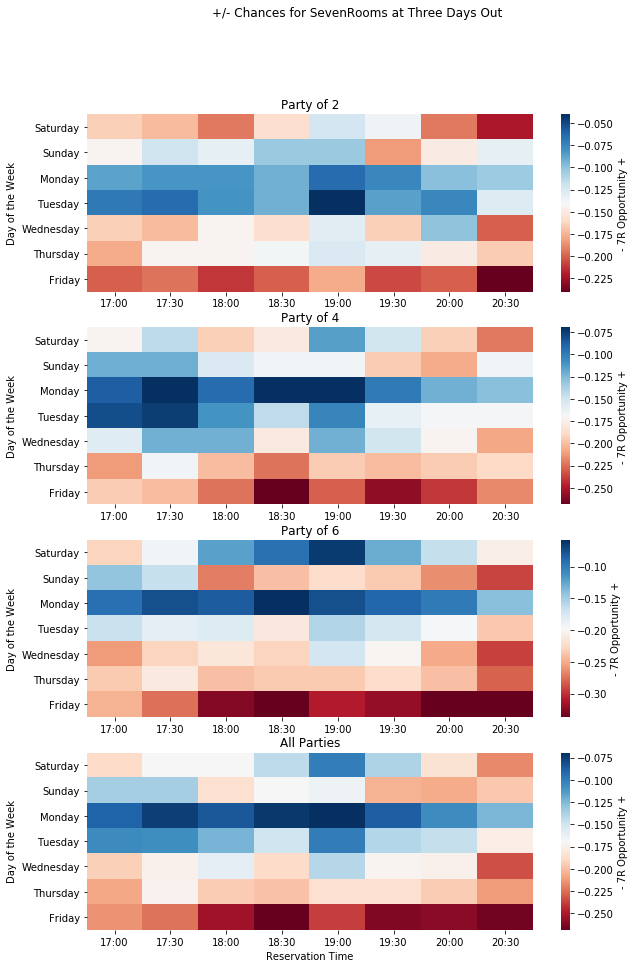

In [39]:
HeatMapIt(threedo, "Three Days Out")

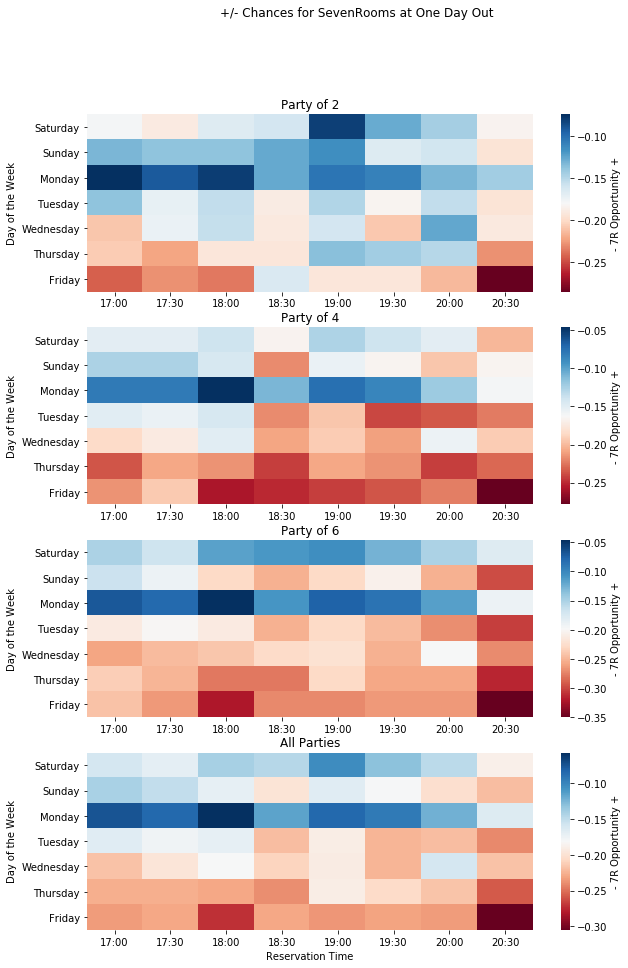

In [40]:
HeatMapIt(onedo, "One Day Out")

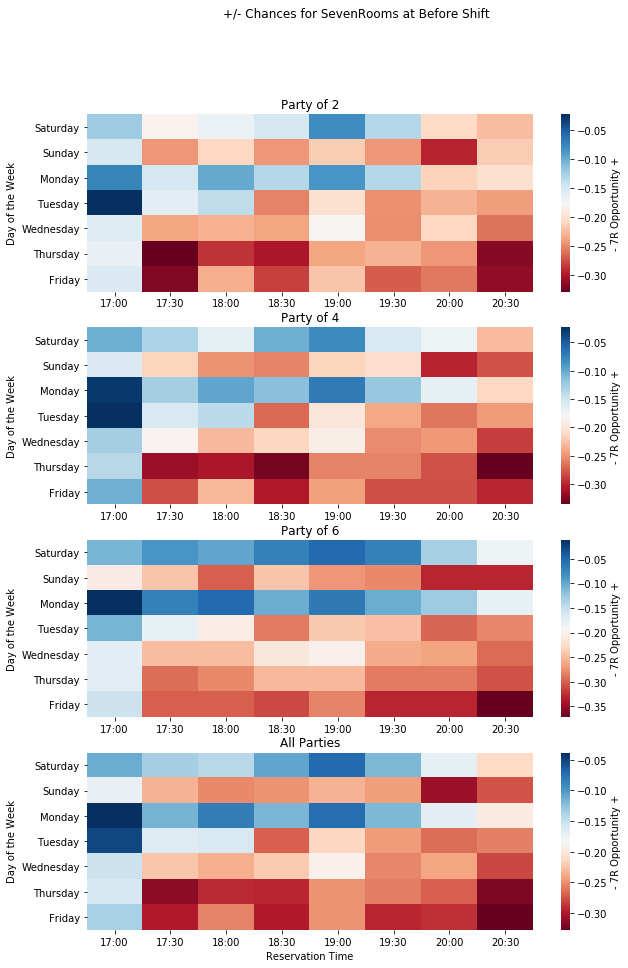

In [41]:
HeatMapIt(bs, "Before Shift")

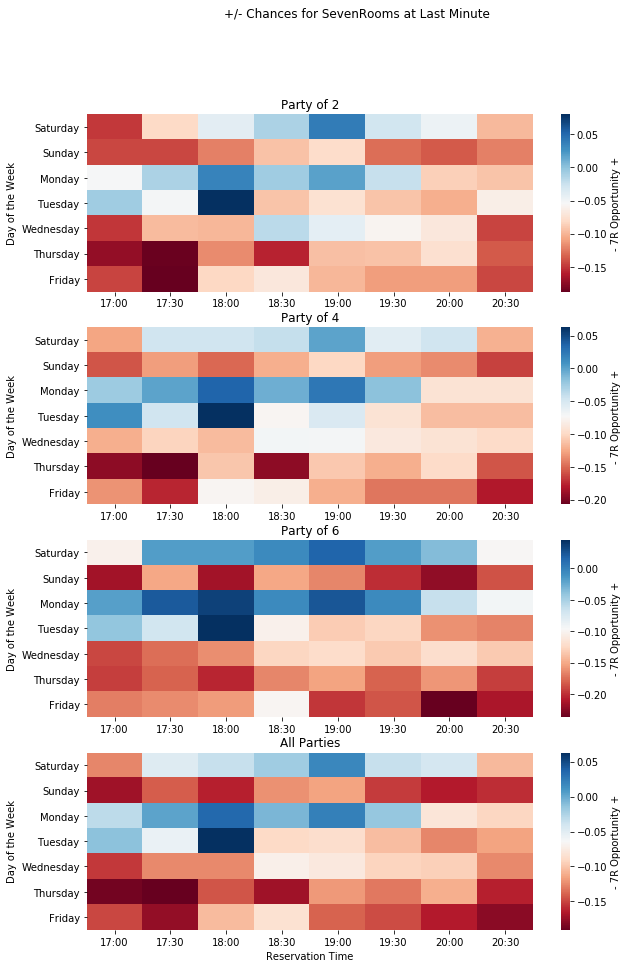

In [42]:
HeatMapIt(lm, "Last Minute")